# Part 1: comparing classifiers

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

In [2]:
import os
import sys


def add_sys_path(p):
    p = os.path.abspath(p)
    print(p)
    if p not in sys.path:
        sys.path.append(p)

In [3]:
from transformers import RobertaTokenizer, RobertaForTokenClassification, RobertaForSequenceClassification
from transformers import BertTokenizer, BertForTokenClassification
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
device = torch.device('cuda:0')

In [11]:
from transformers import Trainer, TrainingArguments
from transformers.file_utils import cached_property
from typing import Tuple

class TrAr(TrainingArguments):
    @cached_property
    def _setup_devices(self):
        return device

In [18]:
class SpansDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = self.labels[idx]
        return {k: torch.tensor(v, dtype=torch.long) for k, v in item.items()}

    def __len__(self):
        return len(self.encodings['input_ids'])

In [5]:
df1 = pd.read_csv('../data/train/train.1.tsv', sep='\t')
df0 = pd.read_csv('../data/train/train_small.0.tsv', sep='\t')
df01 = pd.concat([df1, df0], ignore_index=True)
df01.label = df01.label.astype(int)
print(df01.shape)
df01.sample(3)

(358984, 2)


,comment_text,label
259013,A tax on Rogers and Bell's services to pay Rog...,0
133153,I consider anyone on the right who freely deny...,1
350914,"And perhaps another: ""Blessed are those who se...",0


In [6]:
df_train, df_test = train_test_split(df01, test_size=0.1, random_state=1)

## Simple baselines

The word-level classifier almost does not overfit, and scores 93.2% on the test set. 

The character-ngram classifier has some more learning capacity, and scores 93.7%.

If we increase its vocabulary size, we get even better results of 94.2%.

If we fine-tune a RoBERTa, we get 88% by tuning a head only, and 95% if we tune its body. 

In [26]:
word_pipe = make_pipeline(HashingVectorizer(n_features=32_000), LogisticRegression(C=1, penalty='l2', max_iter=1_000))

In [27]:
word_pipe.fit(df_train.comment_text, df_train.label);

In [28]:
preds = word_pipe.predict_proba(df_train.comment_text)[:, 1]
print(roc_auc_score(df_train.label, preds))

0.9397186371671808


In [29]:
preds = word_pipe.predict_proba(df_test.comment_text)[:, 1]
print(roc_auc_score(df_test.label, preds))

0.9324057891122254


In [31]:
char_pipe = make_pipeline(HashingVectorizer(n_features=32_000, ngram_range=(3,6), analyzer='char_wb'), LogisticRegression(C=1, penalty='l2', max_iter=1_000))
char_pipe.fit(df_train.comment_text, df_train.label);

for table in df_train, df_test:
    preds = char_pipe.predict_proba(table.comment_text)[:, 1]
    print(roc_auc_score(table.label, preds))

0.9451532647499767
0.9369443803559506


In [35]:
char_pipe2 = make_pipeline(HashingVectorizer(n_features=128_000, ngram_range=(3,6), analyzer='char_wb'), LogisticRegression(C=1, penalty='l2', max_iter=1_000, n_jobs=32))
char_pipe2.fit(df_train.comment_text, df_train.label);

for table in df_train, df_test:
    preds = char_pipe2.predict_proba(table.comment_text)[:, 1]
    print(roc_auc_score(table.label, preds))

0.9498664523286193
0.9416081650940398


## A neural baseline

In [7]:
from transformers import RobertaTokenizer, RobertaForTokenClassification, RobertaForSequenceClassification
from transformers import BertTokenizer, BertForTokenClassification
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch

In [8]:
model_name = 'roberta-base' 

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained(model_name)

In [72]:
clf_train_dataset = SpansDataset(
    tokenizer(df_train.comment_text.tolist(), truncation=True), 
    df_train.label.tolist()
)

In [73]:
clf_test_dataset = SpansDataset(
    tokenizer(df_test.comment_text.tolist(), truncation=True), 
    df_test.label.tolist()
)

In [74]:
N = 3000
clf_test_small_dataset = SpansDataset(
    tokenizer(df_test.comment_text.iloc[:N].tolist(), truncation=True), 
    df_test.label[:N].tolist()
)

In [178]:
clf = RobertaForSequenceClassification.from_pretrained(model_name)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [179]:
clf.to(device);

In [180]:
import gc

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [182]:
for param in clf.roberta.parameters():
    param.requires_grad = False

In [183]:
for param in clf.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([768, 768])
torch.Size([768])
torch.Size([2, 768])
torch.Size([2])


In [194]:
training_args = TrAr(
    output_dir='./models/roberta_classifier',   # output directory
    overwrite_output_dir=True,
    num_train_epochs=1,            # total # of training epochs
    per_device_train_batch_size=64,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=100,               # number of warmup steps for learning rate scheduler
    weight_decay=1e-8,              # strength of weight decay
    learning_rate=1e-3,
    logging_dir='./logs',           # directory for storing logs
    logging_steps=100,
    eval_steps=100,
    evaluation_strategy='steps',
    save_total_limit=3,
    load_best_model_at_end=True,
)

In [195]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer, padding=True)

In [196]:
def hf_metric(out):
    return {'roc_auc': roc_auc_score(out.label_ids, out.predictions[:, 1])}

In [197]:
from transformers import EarlyStoppingCallback
esc = EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0)

In [198]:
trainer = Trainer(
    model=clf,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=clf_train_dataset,         # training dataset
    eval_dataset=clf_test_small_dataset,           # evaluation dataset
    #data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=hf_metric,
    callbacks=[esc],
)

In [199]:
hf_metric(trainer.predict(clf_test_small_dataset))

{'roc_auc': 0.569843734247404}

In [200]:
trainer.train()

Step,Training Loss,Validation Loss,Roc Auc,Runtime,Samples Per Second
100,0.667800,0.606639,0.857506,15.969400,187.859000
200,0.602500,0.510367,0.871650,16.054700,186.862000
300,0.554100,0.512327,0.874013,16.069600,186.688000
400,0.536200,0.450778,0.878355,16.080600,186.561000
500,0.517400,0.455767,0.883892,16.075700,186.617000
600,0.531800,0.484408,0.885007,16.060900,186.789000
700,0.533700,0.467164,0.886813,16.071200,186.670000


TrainOutput(global_step=700, training_loss=0.5633628300258091, metrics={'train_runtime': 405.3533, 'train_samples_per_second': 12.456, 'total_flos': 9488996164220160, 'epoch': 0.14})

Second stage of the training: the whole model

In [201]:
for param in clf.parameters():
    param.requires_grad = True

In [233]:
training_args = TrAr(
    output_dir='./models/roberta_classifier',   # output directory
    overwrite_output_dir=True,
    num_train_epochs=1,            # total # of training epochs
    per_device_train_batch_size=4,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=300,               # number of warmup steps for learning rate scheduler
    weight_decay=1e-8,              # strength of weight decay
    learning_rate=1e-5,
    logging_dir='./logs',           # directory for storing logs
    logging_steps=300,
    eval_steps=300,
    evaluation_strategy='steps',
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model='roc_auc',
)

In [236]:
from transformers import EarlyStoppingCallback
esc = EarlyStoppingCallback(early_stopping_patience=5, early_stopping_threshold=0)

In [237]:
trainer = Trainer(
    model=clf,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=clf_train_dataset,         # training dataset
    eval_dataset=clf_test_small_dataset,           # evaluation dataset
    #data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=hf_metric,
    callbacks=[esc],
)

In [238]:
cleanup()

In [239]:
trainer.train()

Step,Training Loss,Validation Loss,Roc Auc,Runtime,Samples Per Second
300,0.440800,0.680429,0.952350,16.145500,185.811000
600,0.310700,0.707914,0.953171,16.086500,186.491000
900,0.299900,1.009980,0.942094,16.082400,186.539000
1200,0.240500,0.902290,0.944559,16.086300,186.494000
1500,0.241100,0.737430,0.952941,16.088300,186.471000
1800,0.215500,0.767514,0.947816,16.086900,186.487000
2100,0.282200,0.911359,0.945745,16.109500,186.225000


TrainOutput(global_step=2100, training_loss=0.2901053474062965, metrics={'train_runtime': 328.7329, 'train_samples_per_second': 245.707, 'total_flos': 876494967183360, 'epoch': 0.03})

In [240]:
hf_metric(trainer.predict(clf_test_dataset))

{'roc_auc': 0.9519475224270993}

# Part 2: show that tagger-classifier is a good classifier

* Tagger-like architecture seems to be more efficient than standard RobertaForSequenceClassification: with a smaller number of parameters, it scores 90% ROC AUC (vs 88% of baseline) when only the head is fine-tuned. 
* When the body is fine-tuned, it converges to the same 95% of ROC AUC as an ordinary classifier

In [241]:
from transformers import RobertaTokenizer, RobertaForTokenClassification, RobertaForSequenceClassification
from transformers import BertTokenizer, BertForTokenClassification
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch

In [242]:
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
from torch.nn import CrossEntropyLoss, MSELoss

class WMean(nn.Module):
    def __init__(self, dim=-2):
        super(WMean, self).__init__()
        self.pow = torch.nn.Parameter(data=torch.Tensor([1.0]), requires_grad=True)
        self.coef = torch.nn.Parameter(data=torch.Tensor([0.0, 1.0]), requires_grad=True)
        self.dim = dim
    
    def forward(self, x, mask=None):
        result = x ** self.pow[0]
        if mask is None:
            mp = result.mean(dim=-1)
        else:
            mp = (result * mask).sum(dim=self.dim) / mask.sum(dim=self.dim)
        return torch.log(mp) * self.coef[1] + self.coef[0]

In [243]:
class RobertaTaggerClassifier(RobertaForTokenClassification):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.roberta = RobertaModel(config, add_pooling_layer=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.wmean = WMean()

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        sequence_output = self.dropout(sequence_output)
        token_logits = self.classifier(sequence_output)

        if attention_mask is not None:
            masks = attention_mask.unsqueeze(-1).repeat(1, 1, 2)
        else:
            masks = None

        logits = self.wmean(torch.softmax(token_logits, dim=-1), mask=masks)

        loss = None
        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [244]:
clf = RobertaTaggerClassifier.from_pretrained('roberta-base')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaTaggerClassifier: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaTaggerClassifier from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaTaggerClassifier from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaTaggerClassifier were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias', 'wmean.pow', 'wmean.coef']
You should probably TRAIN this model on a down-stream task to be a

In [245]:
for param in clf.roberta.parameters():
    param.requires_grad = False

In [246]:
for param in clf.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([2, 768])
torch.Size([2])
torch.Size([1])
torch.Size([2])


In [248]:
training_args = TrAr(
    output_dir='./models/roberta_wm_classifier',   # output directory
    overwrite_output_dir=True,
    num_train_epochs=1,            # total # of training epochs
    per_device_train_batch_size=64,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=100,               # number of warmup steps for learning rate scheduler
    weight_decay=1e-8,              # strength of weight decay
    learning_rate=1e-3,
    logging_dir='./logs',           # directory for storing logs
    logging_steps=100,
    eval_steps=100,
    evaluation_strategy='steps',
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model='roc_auc',
)

In [249]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer, padding=True)

In [250]:
def hf_metric(out):
    return {'roc_auc': roc_auc_score(out.label_ids, out.predictions[:, 1])}

In [251]:
from transformers import EarlyStoppingCallback
esc = EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0)

In [252]:
trainer = Trainer(
    model=clf,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=clf_train_dataset,         # training dataset
    eval_dataset=clf_test_small_dataset,           # evaluation dataset
    #data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=hf_metric,
    callbacks=[esc],
)

In [253]:
hf_metric(trainer.predict(clf_test_small_dataset))

{'roc_auc': 0.5387299346932374}

It's surprising, but this simple trainer seems to be just unable to converge. Why? Is it going asymptotic?

In [254]:
trainer.train()

Step,Training Loss,Validation Loss,Roc Auc,Runtime,Samples Per Second
100,0.657000,0.594520,0.862524,15.926100,188.370000
200,0.561300,0.505007,0.876173,16.024600,187.212000
300,0.503700,0.469456,0.878648,16.079300,186.575000
400,0.476200,0.461533,0.884187,16.091600,186.432000
500,0.461700,0.457068,0.887382,16.086800,186.488000
600,0.462000,0.435209,0.885204,16.093000,186.417000
700,0.462700,0.429421,0.888364,16.091000,186.440000
800,0.458700,0.426974,0.889986,16.092800,186.419000
900,0.445800,0.431917,0.893396,16.079900,186.568000
1000,0.446400,0.420964,0.894024,16.084700,186.513000


TrainOutput(global_step=2800, training_loss=0.4597941248757499, metrics={'train_runtime': 1646.2604, 'train_samples_per_second': 3.067, 'total_flos': 38546066886201600, 'epoch': 0.55})

Second stage of the training: the whole model

In [255]:
for param in clf.parameters():
    param.requires_grad = True

In [256]:
training_args = TrAr(
    output_dir='./models/roberta_wm_classifier',   # output directory
    overwrite_output_dir=True,
    num_train_epochs=1,            # total # of training epochs
    per_device_train_batch_size=4,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=300,               # number of warmup steps for learning rate scheduler
    weight_decay=1e-8,              # strength of weight decay
    learning_rate=1e-5,
    logging_dir='./logs',           # directory for storing logs
    logging_steps=300,
    eval_steps=300,
    evaluation_strategy='steps',
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model='roc_auc',
)

In [257]:
from transformers import EarlyStoppingCallback
esc = EarlyStoppingCallback(early_stopping_patience=10, early_stopping_threshold=0)

In [258]:
trainer = Trainer(
    model=clf,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=clf_train_dataset,         # training dataset
    eval_dataset=clf_test_small_dataset,           # evaluation dataset
    #data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=hf_metric,
    callbacks=[esc],
)

In [259]:
cleanup()

In [260]:
trainer.train()

Step,Training Loss,Validation Loss,Roc Auc,Runtime,Samples Per Second
300,0.530700,0.440437,0.916096,16.182700,185.383000
600,0.629700,0.675921,0.936811,16.076600,186.607000
900,0.617700,0.417694,0.941973,16.071100,186.671000
1200,0.566200,0.631325,0.932847,16.083100,186.531000
1500,0.625600,0.569090,0.938906,16.083500,186.527000
1800,0.571000,0.441794,0.944334,16.088000,186.475000
2100,0.568800,0.556021,0.930812,16.079300,186.575000
2400,0.607300,0.455331,0.939510,16.076000,186.613000
2700,0.487500,0.645248,0.949999,16.089400,186.458000
3000,0.522400,0.425579,0.952864,16.099200,186.345000


TrainOutput(global_step=6000, training_loss=0.5388713582356771, metrics={'train_runtime': 945.9142, 'train_samples_per_second': 85.39, 'total_flos': 2464073343886176, 'epoch': 0.07})

In [261]:
hf_metric(trainer.predict(clf_test_dataset))

{'roc_auc': 0.9516783318837393}

The resulting scores are very, very strange.  

It seems that we do really need multitasking, because without taging superivision at all, we get trash results with e.g punctuation being the most extremely rated. 

In [398]:
for p in clf.wmean.parameters():
    print(p)

Parameter containing:
tensor([1.8128], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.8515, 1.8189], device='cuda:0', requires_grad=True)


In [377]:
import spans_utils
import matplotlib.cm

In [393]:
text = df_test[df_test.label==1].sample(1).iloc[0].comment_text    
inputs = {k: v.to(device) for k, v in tokenizer(text, return_tensors='pt').items()}

clf.eval()

with torch.no_grad():
    preds = clf.classifier(clf.dropout(clf.roberta(**inputs)[0]))
    
scores = preds[0].softmax(-1)[:, 0]
scores = scores[1:-1].cpu().numpy()

tokens = tokenizer.tokenize(text)

spans_utils.display_token_scores(tokens, scores / np.median(scores) * 0.5)

# Part 3: try using a tagger as a classifier 

Идея: посмотреть, насколько теггер токсичных спанов (из задачи https://www.sites.google.com/view/toxicspans) способен решить задачу классификации комментариев. 

Мы уже пробовали трансферить классификацию в тегирование, и получилось так себе. Очень интересно, будет ли работать в другую сторону. 

Если тоже нет, это значит, что, скорее всего, определение токсичности в Jigsaw и в toxicspans всё-таки существенно различается. Потому что сам по себе теггер перформит неплохо. 

С другой стороны, теггер никогда не видел нетоксичных текстов, так что с чего бы ему вообще что-то знать про нетоксичность?

In [7]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

In [8]:
model_path = '../semeval2021/models/roberta_clf_ft'
spans_tokenizer = AutoTokenizer.from_pretrained('roberta-base')
spans_tagger = AutoModelForTokenClassification.from_pretrained(model_path)

In [9]:
spans_tagger.to(device);

In [44]:
df_test.shape

(35899, 2)

In [ ]:
clf_test_dataset = SpansDataset(
    spans_tokenizer(df_test.comment_text.tolist(), truncation=True), 
)

In [43]:
clf_test_dataset[0]

{'input_ids': tensor([    0,  8346,     6,    89,    21,     5, 23629, 12968,   631,     4,
         12526,  1636,  6465,  5726,     6,    54,   393, 11184,    13,    24,
            25,   444,    25,    38,   216,     4,  1437, 50140, 50118,  2409,
         11110,     5, 23629, 12968,   631,    36,  1610, 32565,    10,   367,
           728,     7,   356,    88,    24,     6,  2085,    43,    16,  7159,
             7,     5,  2731,     4,     2]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1])}

In [27]:
training_args = TrAr(
    output_dir='tmp',
    per_device_eval_batch_size=64,
)

In [45]:
from transformers import DataCollatorWithPadding

In [47]:
trainer = Trainer(
    model=spans_tagger,
    args=training_args,
    data_collator=DataCollatorWithPadding(tokenizer=spans_tokenizer)
)

In [48]:
preds = trainer.predict(clf_test_dataset)

In [62]:
proba = np.exp(preds.predictions)
proba /= proba.sum(-1, keepdims=True)

In [63]:
from tqdm.auto import tqdm, trange

In [83]:
max_scores = np.array([pr[:obs['input_ids'].shape[0], 1].max() for obs, pr in zip(tqdm(clf_test_dataset), proba)])

In [80]:
mean_scores = [pr[:obs['input_ids'].shape[0], 1].mean() for obs, pr in zip(clf_test_dataset, proba)]
sum_scores = [pr[:obs['input_ids'].shape[0], 1].sum() for obs, pr in zip(clf_test_dataset, proba)]

logmean_scores = [pr[:obs['input_ids'].shape[0], 1].mean() for obs, pr in zip(clf_test_dataset, np.log(proba))]
logsum_scores = [pr[:obs['input_ids'].shape[0], 1].sum() for obs, pr in zip(clf_test_dataset, np.log(proba))]

In [82]:
print('max\t', roc_auc_score(df_test.label, max_scores))
print('mean\t', roc_auc_score(df_test.label, mean_scores))
print('sum\t', roc_auc_score(df_test.label, sum_scores))
print('logmean\t', roc_auc_score(df_test.label, logmean_scores))
print('logsum\t', roc_auc_score(df_test.label, logsum_scores))

max	 0.9284224310789024
mean	 0.6688997908411966
sum	 0.6664518174212648
logmean	 0.3314395081219059
logsum	 0.47393828428693896


Оказывается, у теггера приличные скоры: 92.8%, против 95.2% у нейроночного классификатора. Оценивать самый токсичный токен - самое здравое. 

Если cкладывать скоры в очень высокой степени (типа 30), получаем тоже хорошие результаты, но число математически это уже практически максимум. 

In [104]:
for p in [0.5, 1, 2, 3, 10, 20, 30, 50, 100, 1000]:
    pmean_scores = [(pr[:obs['input_ids'].shape[0], 1]**p).mean() for obs, pr in zip(clf_test_dataset, proba)]
    print(p, '\t', roc_auc_score(df_test.label, pmean_scores))

0.5 	 0.4655723488480239
1 	 0.6688997908411966
2 	 0.8806614007404695
3 	 0.907694938501369
10 	 0.9253033132240656
20 	 0.9273417204420338
30 	 0.9278425415934849
50 	 0.927552451397623
100 	 0.9130072398811575
1000 	 0.6214589697223271


In [106]:
for p in [0.5, 1, 2, 3, 10, 20, 30, 50, 100, 1000]:
    pmean_scores = [(pr[:obs['input_ids'].shape[0], 1]**p).sum() for obs, pr in zip(clf_test_dataset, proba)]
    print(p, '\t', roc_auc_score(df_test.label, pmean_scores))

0.5 	 0.44866954771466305
1 	 0.6664518174212648
2 	 0.9066887454803618
3 	 0.921574869310578
10 	 0.9282860526301903
20 	 0.9284209891271048
30 	 0.9284236874796511
50 	 0.9280216125081837
100 	 0.9146362051220178
1000 	 0.625298624757893


In [84]:
df_test['pred_score'] = max_scores

/home/dale/p3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


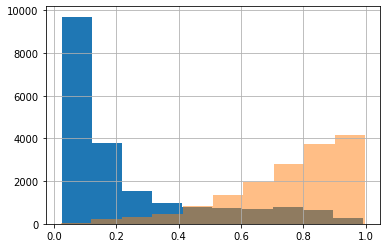

In [92]:
df_test[df_test.label==0].pred_score.hist();
df_test[df_test.label==1].pred_score.hist(alpha=0.5);

In [99]:
pd.options.display.max_colwidth = 500

In [108]:
df_test[(df_test.label==0) & (df_test.pred_score > 0.8)].sample(10)

,comment_text,label,pred_score
181880,This is insane.....,0,0.893508
244421,Yet you don't see a problem with murdering an American serviceman.,0,0.863068
213228,"sustaineugenedotorg.....Hey, quit being so damn negative. Just wait...when the economic ""trickle-down"" starts you will be a happy camper. Don't be discouraged that it's never worked in the past.....don't be distracted by the idea that ""the best predictor or future behavior is past behavior"".......don't be upset the Donald's selecting other billionaires for his cabinet.....after all, being at the ""center"" of an Amway pyramid is indicative of having a real dedication to improving public edu...",0,0.863382
250723,"Tell him that you and the kids will miss him. He has a right to carry the gun openly (assuming the state/county allows this) but your role is keeping your kids safe. Ask your husband to get on-board. If he doesn't, when the BIL comes over, you and kids need to leave. This is non-negotiable. Every.damn.day a child is seriously hurt or killed by a gun. I have friends who have guns in their home, and they know not to even ask if I want to come over to their house. And tell him what I told m...",0,0.828627
216656,"all the sources to eusebius and africanus and Septuagint are all here in wikipedia and apparently youre too stupid to link it as you read it or too lazy to go look thru Wikipedia to find it and see its there. You know-it-alls are like those who negligently built the dykes of new orleans, you should die with the victims who did in new orleans when you negligenlty take any structural matter into your hands, your wives and children should right before your eyes due to the evil in your atitude t...",0,0.893790
314826,That's how the media tries to make a fool of us sometimes. It doesn't even add up.,0,0.839540
355966,"""Greatest traitor"" This is the most appalling letter I've ever read in the RG. It's equal to the hateful tripe Booth wrote about Lincoln.",0,0.811896
277855,Character develops over time. Can the shrinks change it? I doubt it. Fear of certain punishment prevents most crime. Prisons should be more miserable and then life there should be shown per videos in schools.,0,0.812131
191385,"Not me. I don't want to get high. I don't want tobacco smoke or dope smoke, because I'm a cancer survivor. Enforce the by-laws and I don't have a problem. Other than certain BC bud stinks like a skunk.",0,0.823896
206100,"leave it to Kathy to spend more money, she has no idea how to stop spending money that's not hers. What does she care, certainly not about her tax paying constituents.\nWhat a waste of skin.",0,0.853846


In [101]:
df_test[(df_test.label==1) & (df_test.pred_score < 0.2)].sample(10)

,comment_text,label,pred_score
95666,"Do you have ""free speech"" on G%M? Which drug are you taking?",1,0.120124
128576,You are attempting to use logic and reason on folks who possess neither.,1,0.125693
95355,"No, I don't suppose Trump would resign -- he's far too selfish for that; of course, selfishness could lead him to resign if he came to believe that doing so would be in his own best interest. As I've said, I have very mixed feelings about it: I think the country needs the transparency of the impeachment process. I hope there are some people who love or care for Trump who also love and care about the country; but I'm not sure who they are or whether they love the country enough to tell Trump ...",1,0.194154
118639,"Sounds like the analysis of every pro sports team that has been in futility, toiling away for decades....they are just one tiny tweek, one small change in the playbook, or just one small trade for an inconsequential player away from perfection, and eternal championships...\n\nNot gonna happen.",1,0.161133
398,u aint got no pancake mix lady so stopppp,1,0.140863
97750,Yes. Rationalizing your jealousy ? Then become a doctor. Or Serve the public or stop your whining because others are doing better than you because they earned it.,1,0.170173
129596,"A 60s to 70s year-old person, participating in a 2.384 mile-race, has an empty coconut for a head.\nLike the song goes:\nPlenty pupule it's easy to see.",1,0.123686
158826,"Poor Steve. Writing comments in the local paper where one lives is not trolling, it's citizenship.\n\nBut writing the same few comments over and over again, hundreds of times a day, in fora all over the English-speaking world, but only on one topic -- THAT's trolling! Got a mirror?",1,0.171609
30426,We need a fence taller than the Mexican fence because Canadians on average are taller,1,0.125205
9591,wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS w...,1,0.184638


false negatives используют иногда довольно типичные обидные выражения, составленные из необидных слов, а иногда реально нужна логика для понимания обидности (типа *You are attempting to use logic and reason on folks who possess neither.*)

false positives часто реально грубоватые, но иногда это цитаты, а иногда стремноватые слова используются в необидном контексте (*That's how the media tries to make a fool of us sometimes. It doesn't even add up.*)